# 04 - The Unreasonable Effectiveness of Linear Regression
 
 
## All You Need is Linear Regression
 
 
### Why We Need Models
 


In [491]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

import xarray as xr
import pymc as pm

# default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

# color=['0.3', '0.5', '0.7', '0.9']
# linestyle=['-', '--', ':', '-.']
# marker=['o', 'v', 'd', 'p']

# plt.rc('axes', prop_cycle=default_cycler)

# gr.set_default_format("png");

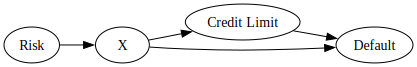

In [12]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

### Regression in A/B Tests


In [13]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [15]:
import arviz as az
import bambi as bmb

# Initialize the fixed effects only model
model = bmb.Model('watch_time ~ recommender', data)

# Fit the model using 1000 on each of 4 chains
results = model.fit(draws=1000, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [watch_time_sigma, Intercept, recommender]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [19]:
model

       Formula: watch_time ~ recommender
        Family: gaussian
          Link: mu = identity
  Observations: 323
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2.1021, sigma: 2.6041)
            recommender ~ Normal(mu: 0.0, sigma: 4.2724)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8258)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, recommender, watch_time_sigma]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'watch_time_sigma'}>,
       <Axes: title={'center': 'recommender\nchallenger'}>], dtype=object)

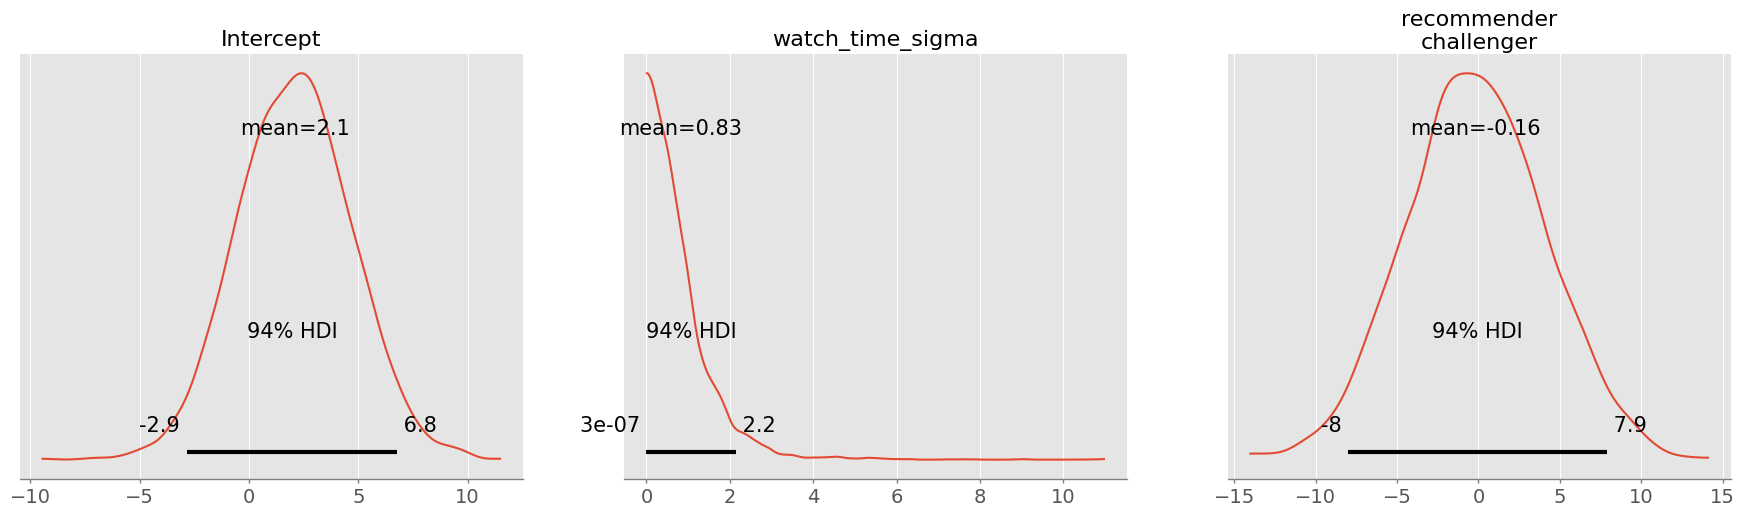

In [20]:
model.plot_priors()

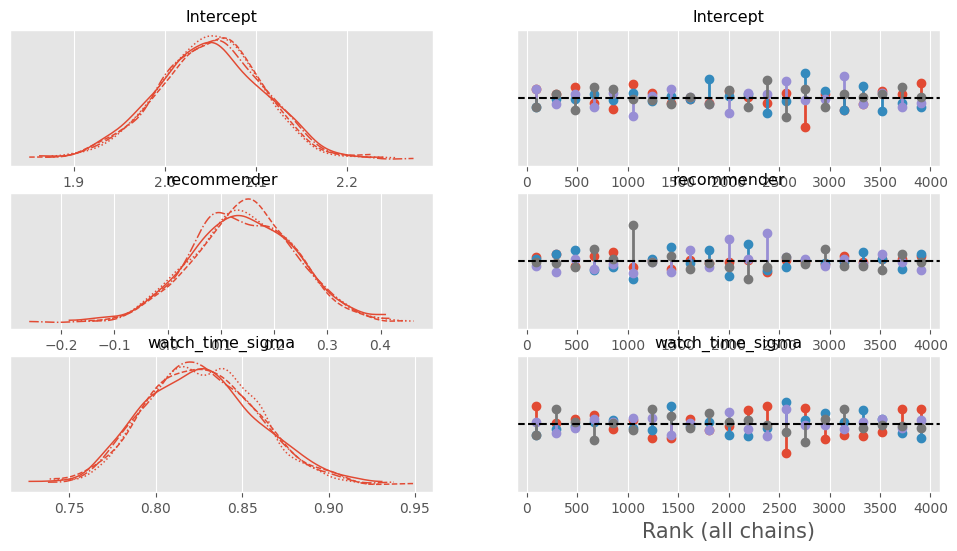

In [16]:
az.plot_trace(results, kind="rank_vlines");

In [18]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.049,0.058,1.937,2.153,0.001,0.000,6808.0,3380.0,1.0
recommender[challenger],0.143,0.096,-0.043,0.315,0.001,0.001,6647.0,3331.0,1.0
watch_time_sigma,0.827,0.033,0.769,0.890,0.000,0.000,6278.0,3085.0,1.0


In [5]:
(data
 .groupby("recommender")
 ["watch_time"]
 .mean())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

### Adjusting with Regression


In [21]:
risk_data = pd.read_csv("./data/risk_data.csv")

risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [256]:
model = bmb.Model('default ~ credit_limit', data=risk_data)

results = model.fit(draws=1000, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.


In [257]:
model.predict(results, kind="pps")

<Axes: xlabel='credit_limit', ylabel='default'>

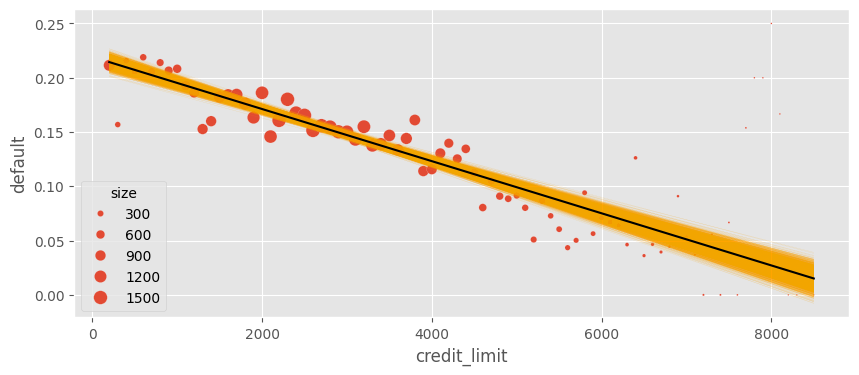

In [260]:
plt_df = (risk_data
.assign(size=1)
.groupby("credit_limit")
.agg({"default": "mean", "size":sum})
.reset_index())

posterior = az.extract_dataset(results)
x_range = xr.DataArray(np.array([min(plt_df['credit_limit']), max(plt_df['credit_limit'])]))
a = posterior['Intercept']
b = posterior['credit_limit']

plt.figure(figsize=(10,4))

# Plot posterior mean and distribution of the regression line
plt.plot(x_range, (a + b * x_range).T, color="orange", lw=0.1, alpha = 0.5)
plt.plot(x_range, a.mean() + b.mean() * x_range, color="black")

# Plot data
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

We can also plot the posterior preditive which shows that the choice of regression for this kind of outcome might be problematic due to it not being bounded to binary space, hence negative default. 

<Axes: xlabel='credit_limit', ylabel='default'>

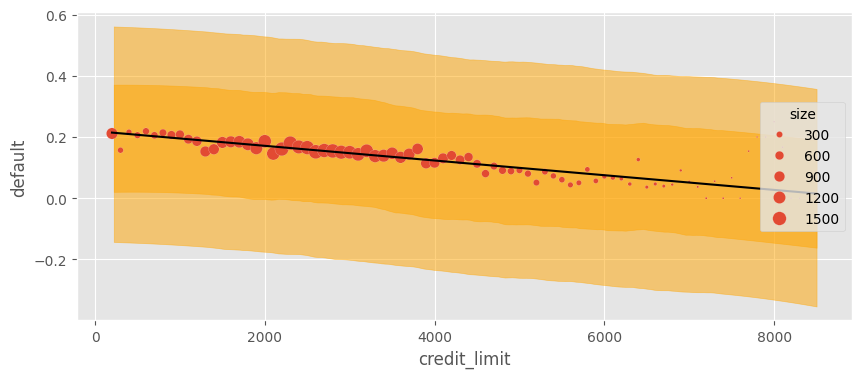

In [261]:
plt_df = (risk_data
.assign(size=1)
.groupby("credit_limit")
.agg({"default": "mean", "size":sum})
.reset_index())

posterior = az.extract_dataset(results)
x_range = xr.DataArray(np.array([min(plt_df['credit_limit']), max(plt_df['credit_limit'])]))
a = posterior['Intercept']
b = posterior['credit_limit']

plt.figure(figsize=(10,4))

# Plot posterior mean and distribution of the regression line
plt.plot(x_range, a.mean() + b.mean() * x_range, color="black")

# Plot posterior pred HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(risk_data['credit_limit'], results.posterior_predictive.default, 
                hdi_prob=interval, color="orange")

# Plot data
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

In [51]:
risk_data.groupby(["credit_score1", "credit_score2"]).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

In [53]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = bmb.Model(formula, data=risk_data)
results = model.fit(draws=1000, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, wage, credit_score1, credit_score2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 275 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.404,0.009,0.388,0.421,0.0,0.0,4691.0,3715.0,1.0
credit_limit,0.000,0.000,-0.000,0.000,0.0,0.0,4835.0,2966.0,1.0
wage,-0.000,0.000,-0.000,-0.000,0.0,0.0,3710.0,3016.0,1.0
credit_score1,-0.000,0.000,-0.000,-0.000,0.0,0.0,4219.0,2748.0,1.0
credit_score2,-0.000,0.000,-0.000,-0.000,0.0,0.0,5198.0,3091.0,1.0
default_sigma,0.352,0.001,0.350,0.355,0.0,0.0,5809.0,2901.0,1.0


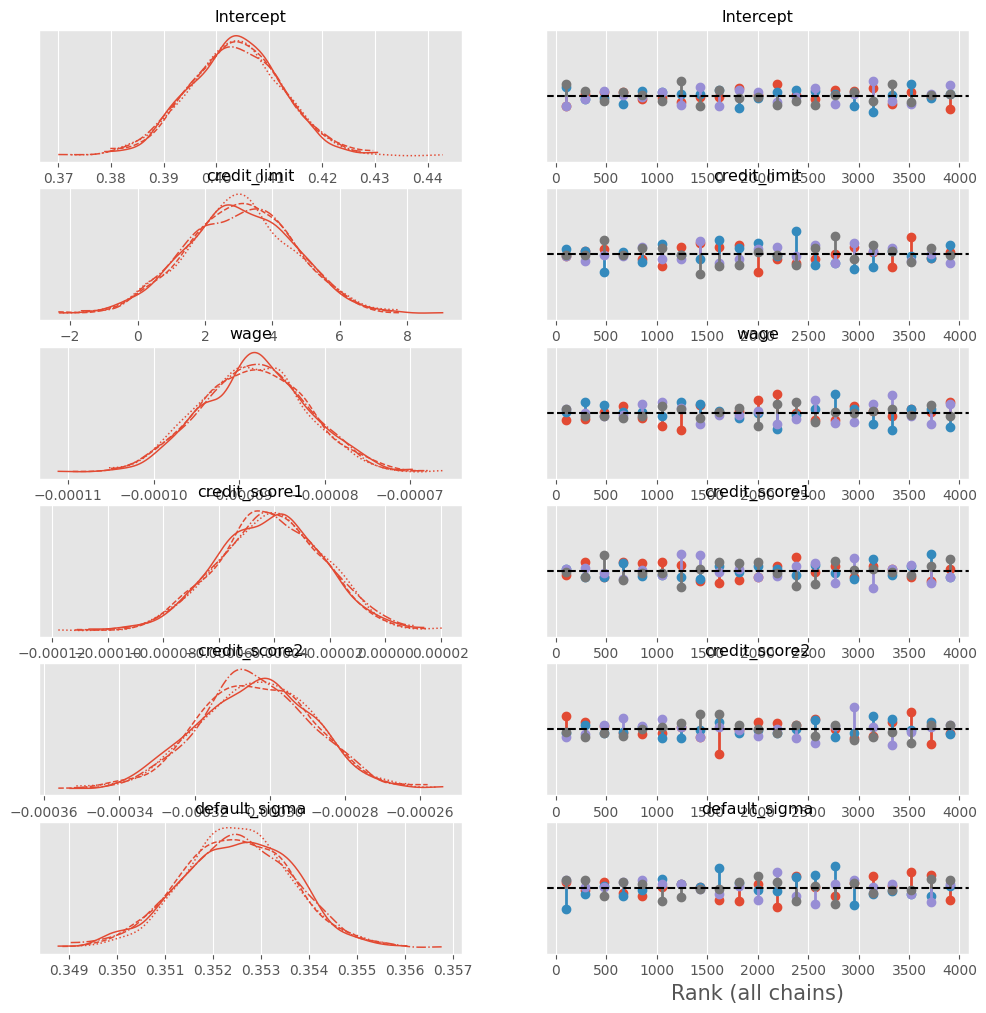

In [59]:
az.plot_trace(results, kind="rank_vlines");

In [58]:
az.summary(results, round_to=9 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.403578,0.008766,3.880607e-01,0.420639,1.279760e-04,9.049900e-05,4691.387262,3714.882469,1.000232
credit_limit,0.000003,0.000002,-1.400000e-08,0.000006,2.300000e-08,1.700000e-08,4835.365016,2966.190047,1.000157
wage,-0.000088,0.000006,-1.000850e-04,-0.000077,1.020000e-07,7.200000e-08,3710.187240,3016.301999,1.000715
credit_score1,-0.000042,0.000019,-7.670700e-05,-0.000006,2.910000e-07,2.130000e-07,4219.347245,2747.870333,1.000099
credit_score2,-0.000304,0.000015,-3.319820e-04,-0.000276,2.080000e-07,1.470000e-07,5198.376661,3091.037752,1.000495
default_sigma,0.352493,0.001132,3.502487e-01,0.354522,1.488700e-05,1.052700e-05,5809.100923,2901.218481,1.000599


## Regression Theory


where does $\hat{\beta} = (X^TX)^{-1}X^TY$ come from? \
$X\hat{\beta}=Y$ \
$X$ is rectangular so cannot invert therefore, \
$X^TX\hat{\beta}=X^TY$ \
$X^TX$ is square so can now invert, \
$\hat{\beta}=(X^TX)^{-1}X^TY$


In [61]:
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"]
X = risk_data[X_cols].assign(intercep=1)
y = risk_data["default"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

 
### Single Variable Linear Regression


### Multivariate Linear Regression


## Frisch-Waugh-Lovell Theorem and Orthogonalization


In [65]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = bmb.Model(formula, data=risk_data)
results = model.fit(draws = 1000, chains = 4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, wage, credit_score1, credit_score2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.


### Debiasing Step


Text(0.5, 1.0, 'Default Rate by Credit Limit')

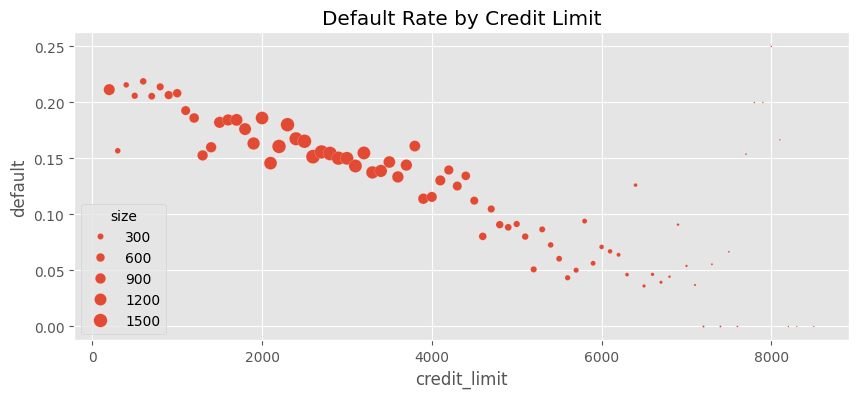

In [66]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")


In [67]:
debiasing_model = bmb.Model(
    'credit_limit ~ wage + credit_score1  + credit_score2',
    data=risk_data
)

results = debiasing_model.fit(draws = 1000, chains = 4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [credit_limit_sigma, Intercept, wage, credit_score1, credit_score2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


In [138]:
preds = bmb.interpret.predictions(debiasing_model, idata=results)
preds['residuals'] = risk_data['credit_limit'] -  preds['estimate']
risk_data_deb = risk_data.assign(
    # for visualization, avg(T) is added to the residuals
    credit_limit_res=(preds['residuals']
                      + risk_data["credit_limit"].mean()),
)

In [98]:
model_w_deb_data = bmb.Model('default ~ credit_limit_res',
                           data=risk_data_deb)
results_w_deb_data = model_w_deb_data.fit(draws = 1000, chains = 4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit_res]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.142,0.005,0.133,0.15,0.0,0.0,5507.0,2700.0,1.0
credit_limit_res,0.000,0.000,0.000,0.00,0.0,0.0,5777.0,2844.0,1.0
default_sigma,0.358,0.001,0.356,0.36,0.0,0.0,5932.0,3130.0,1.0


In [99]:
az.summary(results_w_deb_data, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.141980,0.004666,1.328388e-01,0.150483,6.330100e-05,4.476300e-05,5507.368787,2699.873884,1.001286
credit_limit_res,0.000003,0.000002,3.760000e-07,0.000006,2.000000e-08,1.600000e-08,5776.869319,2843.521236,1.001560
default_sigma,0.357852,0.001126,3.556653e-01,0.359866,1.461900e-05,1.033800e-05,5931.779717,3129.620261,1.002076


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'credit_limit_res'}>,
        <Axes: title={'center': 'credit_limit_res'}>],
       [<Axes: title={'center': 'default_sigma'}>,
        <Axes: title={'center': 'default_sigma'}>]], dtype=object)

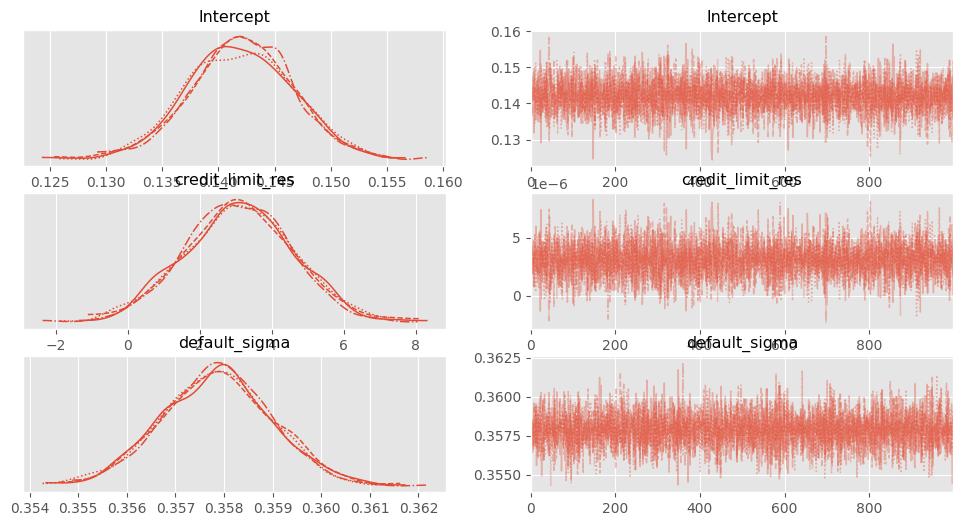

In [101]:
az.plot_trace(results_w_deb_data)

Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

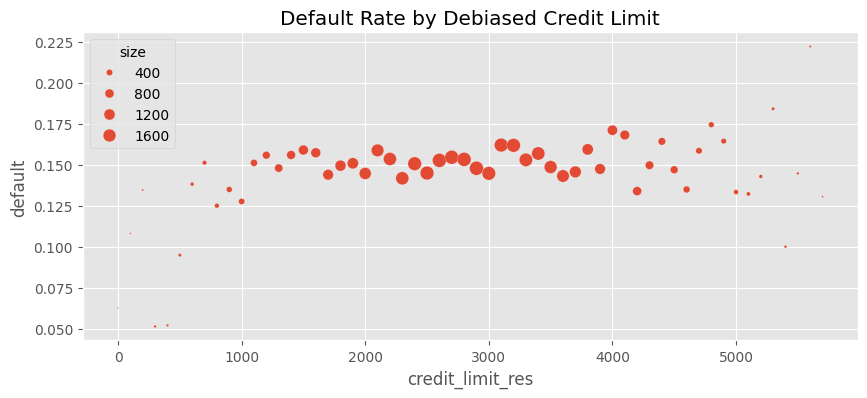

In [128]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

(risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res_lower = lambda d: d["credit_limit_res_lower"].round(-2))
          .groupby("credit_limit_res_lower")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())   

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")


### Denoising Step


In [134]:
denoising_model = bmb.Model(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data_deb
)

results_denoising = denoising_model.fit(draws = 1000, chains = 4, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [default_sigma, Intercept, wage, credit_score1, credit_score2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.


In [139]:
preds = bmb.interpret.predictions(denoising_model, idata=results_denoising)
preds['residuals'] = risk_data['default'] -  preds['estimate']
risk_data_denoise= risk_data_deb.assign(
    # for visualization, avg(T) is added to the residuals
    default_res=(preds['residuals']
                      + risk_data["default"].mean()),
)

### Standard Error of the Regression Estimator

In [18]:
model_se = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

print("SE regression:", model_se.bse["wage"])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data=risk_data
).fit()

# subtract the degrees of freedom - 4 model parameters - from N.
se_formula = (np.std(model_se.resid)
              /(np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4)))

print("SE formula:   ", se_formula)

SE regression: 5.364242347548197e-06
SE formula:    5.364242347548201e-06


### Final Outcome Model


In [141]:
model_w_orthogonal = bmb.Model('default_res ~ credit_limit_res',
                             data=risk_data_denoise)
results_w_orthogonal = model_w_orthogonal.fit(draws = 1000, chains = 4, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [default_res_sigma, Intercept, credit_limit_res]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.142,0.005,0.133,0.151,0.0,0.0,6181.0,2858.0,1.0
credit_limit_res,0.000,0.000,0.000,0.000,0.0,0.0,5953.0,3238.0,1.0
default_res_sigma,0.352,0.001,0.350,0.355,0.0,0.0,6943.0,3232.0,1.0


In [ ]:
az.summary(results_w_orthogonal, round_to=9)

Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit')

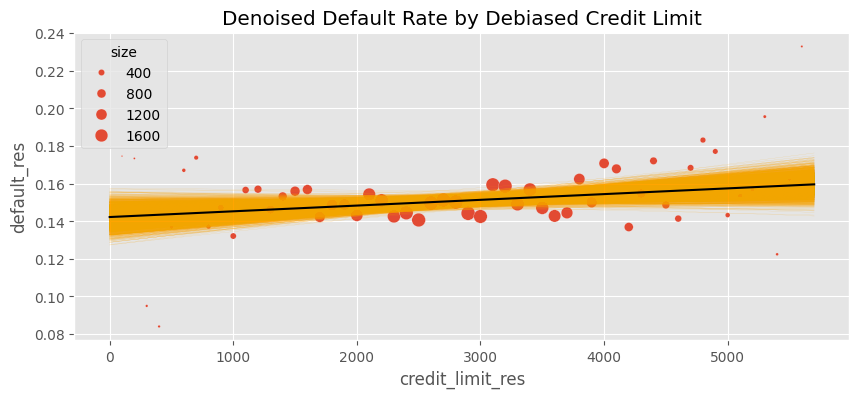

In [255]:
plt_df = (risk_data_denoise
.assign(size=1)
.assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
.groupby("credit_limit_res")
.agg({"default_res": "mean", "size":sum})
.query("size>30")
.reset_index())

posterior = az.extract_dataset(results_w_orthogonal)
x_range = xr.DataArray(np.array([min(plt_df['credit_limit_res']), max(plt_df['credit_limit_res'])]))
a = posterior['Intercept']
b = posterior['credit_limit_res']

plt.figure(figsize=(10,4))

# Plot posterior mean and distribution of the regression line
plt.plot(x_range, (a + b * x_range).T, color="orange", lw=0.1, alpha = 0.5)
plt.plot(x_range, a.mean() + b.mean() * x_range, color="black")

# Plot data
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.title("Denoised Default Rate by Debiased Credit Limit")


### FWL Summary


## Regression as an Outcome Model


## Positivity and Extrapolation


Text(0.5, 1.0, 'Dataset 2')

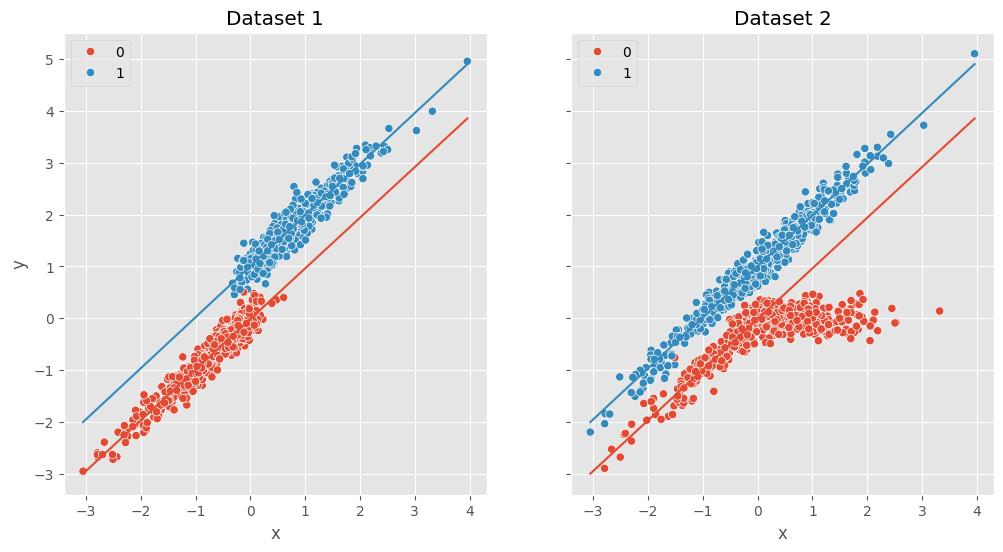

In [295]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1)

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2)

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")

## Non-Linearities in Linear Regression


In [296]:
spend_data = pd.read_csv("./data/spend_data.csv")

spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


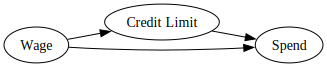

In [297]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

<Axes: xlabel='credit_limit', ylabel='spend'>

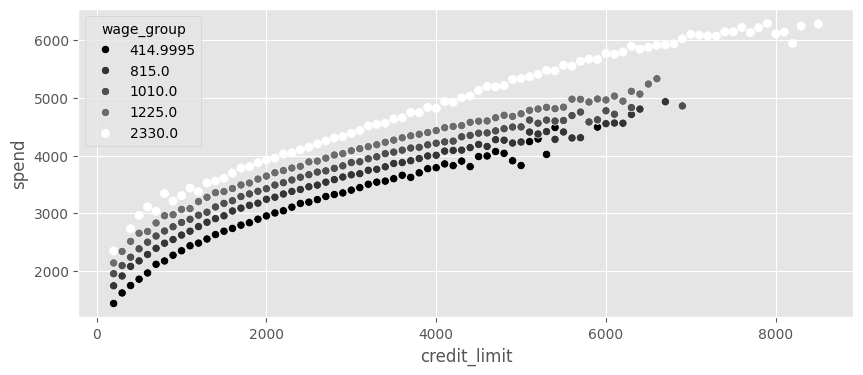

In [298]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")


![img](./data/img/code-img/04-img8.png)

Rather, the treatment response curve seems to have some sort of concavity to it: the higher the credit limit, the lower the slope of this curve. Or, in causal inference language, since slopes and causal effects are intimately related, you can also say that the effect of lines on spend diminishes as you increase lines: going from a line of 1000 to 2000 increases spend more than going from 2000 to 3000. 
 
### Linearizing the Treatment
 
To deal with that, you first need to transform the treatment into something that does have a linear relationship with the outcome. For instance, you know that the relationship seems concave, so you can try to apply some concave function to lines. Some good candidates to try out are the Log function, the square root function or any function that takes credit lines to the power of a fraction. 
 
In this case, let's try the square root:

<Axes: xlabel='credit_limit_sqrt', ylabel='spend'>

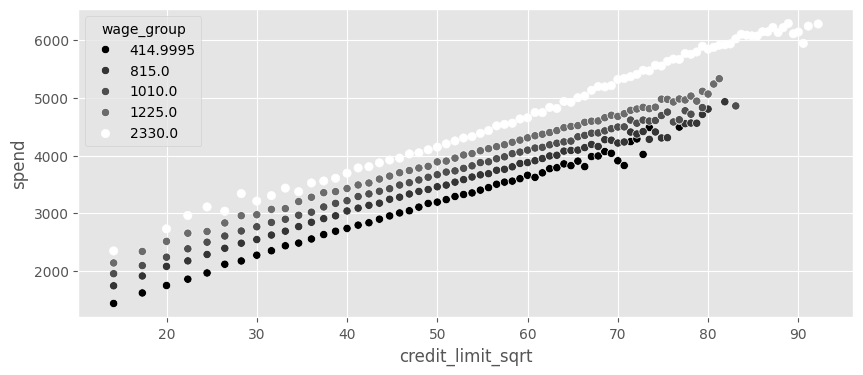

In [301]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # create 5 wage binds for better vizualization
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")


In [345]:
model_spend = bmb.Model(
    'spend ~ np.sqrt(credit_limit)',data=spend_data
)

results_spend = model_spend.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [spend_sigma, Intercept, np.sqrt(credit_limit)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [346]:
az.summary(results_spend)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,493.052,6.209,480.841,503.924,0.109,0.077,3266.0,1507.0,1.0
np.sqrt(credit_limit),63.252,0.117,63.032,63.471,0.002,0.001,3422.0,1632.0,1.0
spend_sigma,373.913,1.184,371.780,376.158,0.019,0.013,4157.0,1529.0,1.0


<Axes: xlabel='credit_limit', ylabel='spend'>

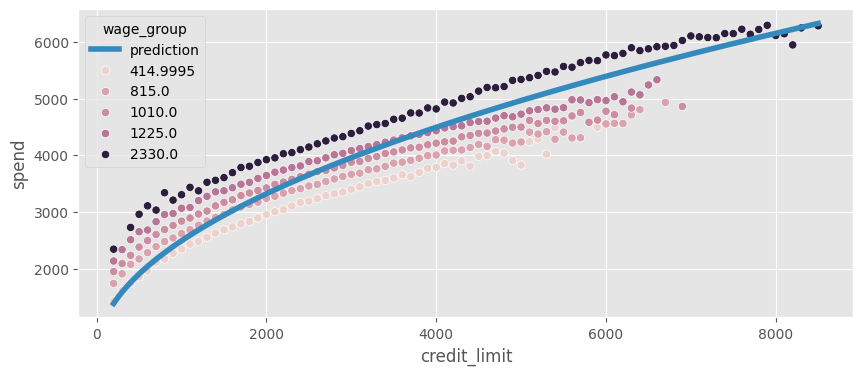

In [347]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )
posterior = az.extract_dataset(results_spend)
x = xr.DataArray(np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max(), 2000))
a = posterior['Intercept']
b = posterior['np.sqrt(credit_limit)']

plt.figure(figsize=(10,4))
plt.plot(x, a.mean() + b.mean()*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group")



In [341]:
model_spend = bmb.Model('spend ~ np.sqrt(credit_limit)+wage',
                      data=spend_data)

results_spend = model_spend.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [spend_sigma, Intercept, np.sqrt(credit_limit), wage]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [342]:
az.summary(results_spend)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,383.507,2.792,378.182,388.703,0.059,0.042,2258.0,1848.0,1.0
np.sqrt(credit_limit),43.849,0.065,43.723,43.964,0.002,0.002,904.0,1239.0,1.0
wage,1.046,0.002,1.042,1.050,0.000,0.000,1252.0,1369.0,1.0
spend_sigma,157.381,0.494,156.404,158.224,0.011,0.008,1942.0,1125.0,1.0


### Non-Linear FWL and Debiasing


In [348]:
debias_spend_model = bmb.Model(f'np.sqrt(credit_limit) ~ wage',
                             data=spend_data)
debias_spend_results = debias_spend_model.fit(cores=1)

denoise_spend_model = bmb.Model(f'spend ~ wage', data=spend_data)

denoise_spend_results = denoise_spend_model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.sqrt(credit_limit)_sigma, Intercept, wage]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [spend_sigma, Intercept, wage]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [351]:
debias_preds = bmb.interpret.predictions(debias_spend_model, idata=debias_spend_results)
debias_preds['residuals'] = np.sqrt(spend_data['credit_limit']) -  debias_preds['estimate']

denoise_preds = bmb.interpret.predictions(denoise_spend_model, idata=denoise_spend_results)
denoise_preds['residuals'] = spend_data['spend'] -  denoise_preds['estimate']

In [355]:
credit_limit_sqrt_deb = (debias_preds['residuals']
                         + np.sqrt(spend_data["credit_limit"]).mean())
spend_den = denoise_preds['residuals'] + spend_data["spend"].mean()


spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                          spend_den = spend_den))

final_model = bmb.Model(f'spend_den ~ credit_limit_sqrt_deb',
                      data=spend_data_deb)
final_model_results = final_model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [spend_den_sigma, Intercept, credit_limit_sqrt_deb]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [356]:
az.summary(final_model_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1493.712,3.420,1487.396,1500.308,0.059,0.042,3357.0,1692.0,1.0
credit_limit_sqrt_deb,43.850,0.065,43.715,43.963,0.001,0.001,3464.0,1749.0,1.0
spend_den_sigma,157.369,0.500,156.518,158.381,0.008,0.006,3659.0,1519.0,1.0


<Axes: xlabel='credit_limit', ylabel='spend'>

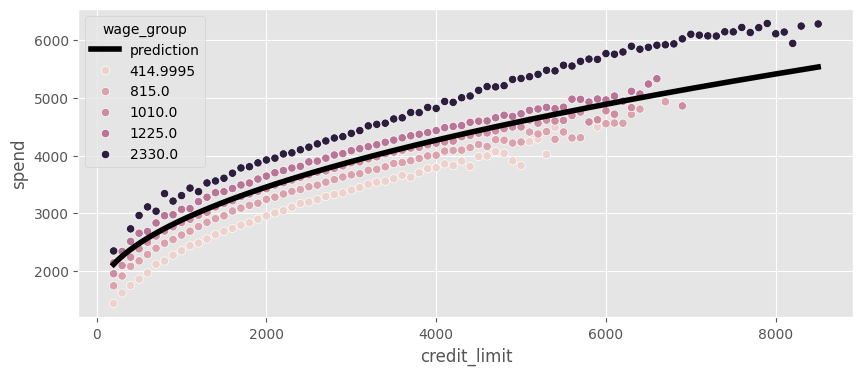

In [404]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

posterior = az.extract_dataset(final_model_results)
x = xr.DataArray(np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max(), 2000))
a = posterior['Intercept']
b = posterior['credit_limit_sqrt_deb']

plt.figure(figsize=(10,4))
plt.plot(x, (a.mean()
             + b.mean()*np.sqrt(x)),
         color="black", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group")


## Regression for Dummies
 
### Conditionally Random Experiments


In [405]:
risk_data_rnd = pd.read_csv("./data/risk_data_rnd.csv")
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


Text(0.5, 1.0, 'Conditional random experiment')

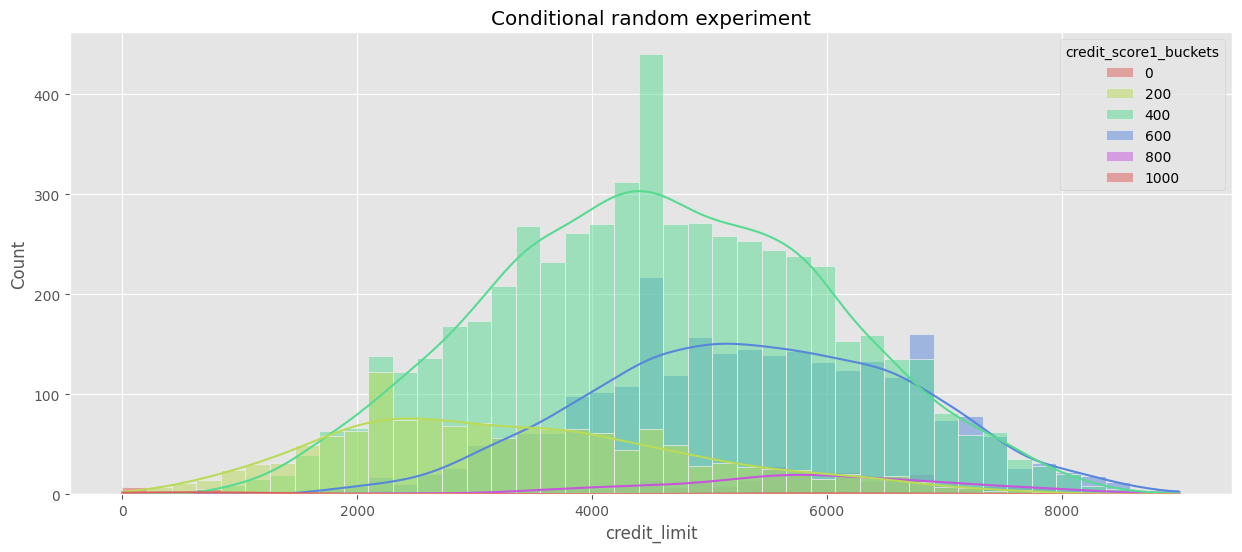

In [407]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="hls");
plt.title("Conditional random experiment")

### Dummy Variables
 


In [409]:
model = bmb.Model("default ~ credit_limit", data=risk_data_rnd)
results = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [411]:
az.summary(results, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.137123,0.009005,0.118852,0.153207,1.616150e-04,1.150000e-04,3109.118464,1666.003185,1.000083
credit_limit,-0.000009,0.000002,-0.000013,-0.000006,3.300000e-08,2.400000e-08,3131.138239,1609.666274,1.001031
default_sigma,0.290839,0.002092,0.287123,0.294923,4.007800e-05,2.834700e-05,2719.549959,1601.548387,1.000918


In [412]:
pd.set_option('display.max_columns', 9)

In [413]:
risk_data_dummies = (risk_data_rnd
                     .join(pd.get_dummies(risk_data_rnd["credit_score1_buckets"],
                                          prefix="sb",
                                          drop_first=True)))
risk_data_dummies.head()

,wage,educ,exper,married,...,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,...,True,False,False,False
1,670.0,11,7,1,...,False,False,False,False
2,1220.0,14,9,1,...,True,False,False,False
3,1210.0,15,8,1,...,False,True,False,False
4,900.0,16,1,1,...,False,False,False,False


In [414]:
model = bmb.Model(
    "default ~ credit_limit + sb_200+sb_400+sb_600+sb_800+sb_1000",
    data=risk_data_dummies
)
results = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, sb_200, sb_400, sb_600, sb_800, sb_1000]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 83 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [415]:
az.summary(results, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.227609,0.053838,1.287378e-01,0.324964,2.477406e-03,1.786289e-03,480.064420,760.881634,1.003392
credit_limit,0.000005,0.000002,9.030000e-07,0.000009,4.800000e-08,3.600000e-08,1810.284988,1091.415093,1.002263
sb_200,-0.058493,0.054790,-1.622015e-01,0.035681,2.558845e-03,1.810529e-03,465.134504,785.913684,1.004048
sb_400,-0.146652,0.054485,-2.381046e-01,-0.039923,2.540979e-03,1.851339e-03,466.663866,781.913587,1.004137
sb_600,-0.217056,0.055038,-3.146971e-01,-0.113629,2.581813e-03,1.870137e-03,459.163547,693.443240,1.004256
sb_800,-0.251301,0.058275,-3.618290e-01,-0.147090,2.632545e-03,1.898089e-03,490.255581,805.128254,1.003792
sb_1000,-0.256477,0.093061,-4.198456e-01,-0.080684,3.423854e-03,2.421987e-03,749.213230,1116.606335,1.002561
default_sigma,0.286953,0.002064,2.832993e-01,0.291180,5.217100e-05,3.689800e-05,1559.032440,1363.812431,1.000988


In [418]:
model = bmb.Model("default ~ credit_limit + C(credit_score1_buckets)",
                data=risk_data_rnd)
results = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, C(credit_score1_buckets)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 71 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [420]:
az.summary(results, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.232736,0.055575,1.290929e-01,0.336520,2.368317e-03,1.683019e-03,552.739678,891.731737,1.003366
credit_limit,0.000005,0.000002,4.250000e-07,0.000008,5.000000e-08,3.800000e-08,1708.585163,1073.978702,1.000410
C(credit_score1_buckets)[200],-0.063641,0.056185,-1.732712e-01,0.038248,2.459846e-03,1.740347e-03,521.491831,834.362451,1.004432
C(credit_score1_buckets)[400],-0.152137,0.055715,-2.619734e-01,-0.054256,2.455195e-03,1.746555e-03,516.648678,774.652571,1.003628
C(credit_score1_buckets)[600],-0.222608,0.056103,-3.236322e-01,-0.113402,2.492763e-03,1.777836e-03,506.977144,905.297659,1.004305
C(credit_score1_buckets)[800],-0.257165,0.058443,-3.602226e-01,-0.143072,2.535305e-03,1.804759e-03,532.568254,854.330737,1.003165
C(credit_score1_buckets)[1000],-0.265836,0.093252,-4.324412e-01,-0.078234,2.745185e-03,1.992315e-03,1160.096615,1323.037321,1.004602
default_sigma,0.286977,0.002016,2.833759e-01,0.290804,4.355400e-05,3.080200e-05,2140.994679,1367.799900,1.001157


In [423]:
preds = bmb.interpret.predictions(model, results)

In [430]:
preds

,credit_limit,credit_score1_buckets,estimate,lower_3.0%,upper_97.0%
0,5400.0,400,0.106233,0.098387,0.114221
1,3800.0,200,0.187133,0.174199,0.203084
2,5800.0,400,0.108131,0.099236,0.116744
3,6500.0,600,0.040983,0.029282,0.051505
4,2100.0,200,0.179063,0.163924,0.195165
...,...,...,...,...,...
9995,5200.0,400,0.105283,0.097677,0.112842
9996,3200.0,400,0.095789,0.087513,0.104990
9997,1900.0,400,0.089618,0.077470,0.102197
9998,5400.0,600,0.035761,0.025816,0.046535


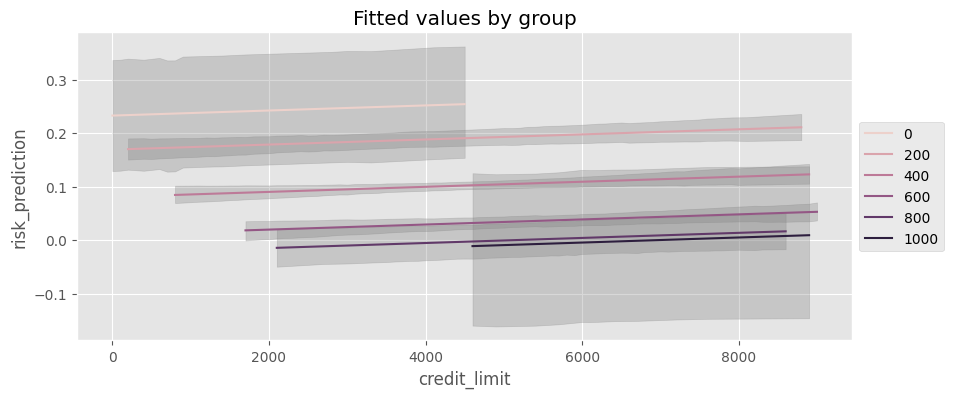

In [439]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = preds['estimate'], 
                  risk_prediction_upper = preds['upper_97.0%'], 
                  risk_prediction_lower = preds['lower_3.0%'])
          .groupby(["credit_limit", "credit_score1_buckets"])
          [["risk_prediction", "risk_prediction_upper", "risk_prediction_lower"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets");
for bucket in plt_df['credit_score1_buckets'].unique():
        plt_df_error = plt_df[plt_df['credit_score1_buckets'] == bucket]
        plt.fill_between(plt_df_error["credit_limit"], 
                         plt_df_error['risk_prediction_upper'], 
                         plt_df_error['risk_prediction_lower'], alpha = 0.3, color = 'grey')
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### Saturated Regression Model


In [440]:
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t]

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets")
                   .apply(regress, y="default", t="credit_limit"))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [442]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.490445628748724e-06

In [443]:
model = bmb.Model("default ~ credit_limit * C(credit_score1_buckets)",
                data=risk_data_rnd)
result = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, C(credit_score1_buckets), credit_limit:C(credit_score1_buckets)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 489 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [445]:
az.summary(result, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.305277,0.071393,0.174776,0.435976,0.003162,0.002237,511.714207,933.671888,1.003538
credit_limit,-0.000066,0.000041,-0.000144,0.000008,0.000002,0.000001,442.284028,743.163109,1.005891
C(credit_score1_buckets)[200],-0.143702,0.073489,-0.282332,-0.009138,0.003206,0.002268,528.842053,884.218709,1.004006
C(credit_score1_buckets)[400],-0.225676,0.072608,-0.354044,-0.090900,0.003150,0.002228,536.776166,924.654007,1.003401
C(credit_score1_buckets)[600],-0.286325,0.075065,-0.419998,-0.139247,0.003235,0.002289,538.392476,1003.429961,1.004372
C(credit_score1_buckets)[800],-0.312681,0.107983,-0.531492,-0.122066,0.004266,0.003018,644.226706,1071.996910,1.000126
C(credit_score1_buckets)[1000],-0.308204,0.425597,-1.072667,0.459488,0.013112,0.009535,1056.435238,1269.724461,1.001582
credit_limit:C(credit_score1_buckets)[200],0.000073,0.000041,-0.000003,0.000149,0.000002,0.000001,446.004959,722.383545,1.004928
credit_limit:C(credit_score1_buckets)[400],0.000071,0.000041,-0.000004,0.000147,0.000002,0.000001,445.558561,744.338235,1.006402
credit_limit:C(credit_score1_buckets)[600],0.000069,0.000041,-0.000006,0.000146,0.000002,0.000001,444.970704,741.443946,1.005845


In [42]:
(model.params[model.params.index.str.contains("credit_limit:")]
 + model.params["credit_limit"]).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]    0.000000
dtype: float64

In [454]:
res_sum = az.summary(result, round_to=9)
(res_sum.loc[res_sum.index.str.contains("credit_limit:"), ["mean",	"sd",	"hdi_3%",	"hdi_97%"]]
 + res_sum.loc["credit_limit", ["mean",	"sd",	"hdi_3%",	"hdi_97%"]])

,mean,sd,hdi_3%,hdi_97%
credit_limit:C(credit_score1_buckets)[200],6.970000e-06,0.000082,-0.000147,0.000157
credit_limit:C(credit_score1_buckets)[400],4.986000e-06,0.000082,-0.000148,0.000155
credit_limit:C(credit_score1_buckets)[600],3.110000e-06,0.000082,-0.000150,0.000154
credit_limit:C(credit_score1_buckets)[800],1.903000e-06,0.000084,-0.000163,0.000154
credit_limit:C(credit_score1_buckets)[1000],9.620000e-07,0.000117,-0.000206,0.000221


In [455]:
preds = bmb.interpret.predictions(model, result)

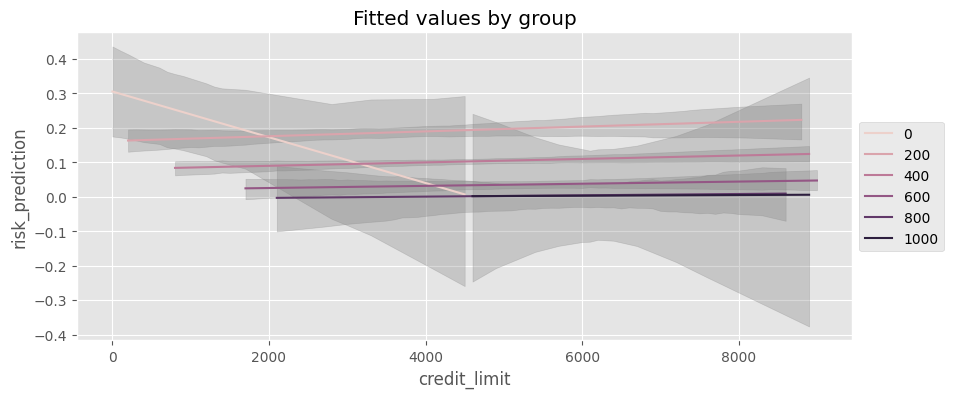

In [457]:
# Plotting the posterior here actually shows much clearer that you cannot trust the inference for many of these groups
plt_df = (risk_data_rnd
          .assign(risk_prediction = preds['estimate'], 
                  risk_prediction_upper = preds['upper_97.0%'], 
                  risk_prediction_lower = preds['lower_3.0%'])
          .groupby(["credit_limit", "credit_score1_buckets"])
          [["risk_prediction", "risk_prediction_upper", "risk_prediction_lower"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets");
for bucket in plt_df['credit_score1_buckets'].unique():
        plt_df_error = plt_df[plt_df['credit_score1_buckets'] == bucket]
        plt.fill_between(plt_df_error["credit_limit"], 
                         plt_df_error['risk_prediction_upper'], 
                         plt_df_error['risk_prediction_lower'], alpha = 0.3, color = 'grey')
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Regression as Variance Weighted Average


In [459]:
np.random.seed(123)

# std(t)=1
t1 = np.random.normal(0, 1, size=1000)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1, # ATE of 1
    g=1,
))

# std(t)=2
t2 = np.random.normal(0, 2, size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2, # ATE of 2
    g=2,
))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [460]:
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group *
       df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate

1.3333333333333333

In [462]:
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

### De-Meaning and Fixed Effects


In [463]:
model_deb = bmb.Model("credit_limit ~ C(credit_score1_buckets)",
                    data=risk_data_rnd)
results = model_deb.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [credit_limit_sigma, Intercept, C(credit_score1_buckets)]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.


In [464]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1177.279,281.701,673.795,1728.409,8.887,6.351,1006.0,1524.0,1.0
C(credit_score1_buckets)[200],2191.090,283.658,1652.666,2711.161,8.909,6.302,1017.0,1466.0,1.0
C(credit_score1_buckets)[400],3398.024,282.363,2849.084,3902.396,8.906,6.299,1007.0,1462.0,1.0
C(credit_score1_buckets)[600],4187.373,282.235,3618.094,4676.276,8.909,6.301,1006.0,1494.0,1.0
C(credit_score1_buckets)[800],4636.720,293.321,4107.581,5201.577,9.000,6.366,1060.0,1583.0,1.0
C(credit_score1_buckets)[1000],5008.459,465.378,4150.635,5913.783,11.299,7.991,1694.0,2190.0,1.0
credit_limit_sigma,1422.597,9.738,1404.445,1441.128,0.163,0.115,3613.0,2614.0,1.0


In [48]:
risk_data_rnd.groupby("credit_score1_buckets")["credit_limit"].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [465]:
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean"))
)

In [467]:
model = bmb.Model("default ~ I(credit_limit-credit_limit_avg)",
                data=risk_data_fe)
results = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, I(credit_limit - credit_limit_avg)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [469]:
az.summary(results, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.093532,0.002847,8.831524e-02,0.099348,5.226300e-05,3.699900e-05,2984.114390,1246.568810,1.000097
I(credit_limit - credit_limit_avg),0.000005,0.000002,7.590000e-07,0.000009,4.000000e-08,3.200000e-08,2590.594285,1349.527785,1.002287
default_sigma,0.291078,0.002072,2.870188e-01,0.294859,3.918500e-05,2.771100e-05,2794.646605,1801.401225,1.002059


In [470]:
model = bmb.Model("default ~ credit_limit + credit_limit_avg",
                data=risk_data_fe)
result = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, credit_limit_avg]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [472]:
az.summary(result, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.432468,0.019665,3.963370e-01,0.470944,3.903140e-04,2.764660e-04,2519.586852,1687.032986,1.000255
credit_limit,0.000005,0.000002,8.970000e-07,0.000008,4.800000e-08,3.500000e-08,1892.977139,1554.644853,0.999801
credit_limit_avg,-0.000078,0.000005,-8.645700e-05,-0.000069,1.110000e-07,7.900000e-08,1815.653856,1777.890965,1.000858
default_sigma,0.287051,0.002067,2.828133e-01,0.290490,3.522700e-05,2.491500e-05,3408.422174,1463.653936,1.001752


## Omitted Variable Bias: Confounding Through the Lens of Regression


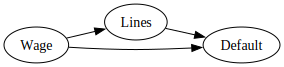

In [473]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("Lines", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Lines")


g

In [474]:
short_model = bmb.Model("default ~ credit_limit", data=risk_data)
short_result = short_model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 82 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [477]:
az.summary(short_result, round_to=9).loc['credit_limit', 'mean']

-2.4014e-05

In [478]:
long_model = bmb.Model("default ~ credit_limit + wage",
                     data=risk_data)

long_result = long_model.fit(cores=1)

omitted_model = bmb.Model("wage ~ credit_limit", data=risk_data)

omitted_result = omitted_model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, wage]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [wage_sigma, Intercept, credit_limit]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [479]:
(az.summary(long_result, round_to=9).loc['credit_limit', 'mean']
 + az.summary(long_result, round_to=9).loc['wage', 'mean']*az.summary(omitted_result, round_to=9).loc['credit_limit', 'mean'])

-2.4015467144543998e-05

In [480]:
az.summary(long_result, round_to=9).loc['wage', 'mean']*az.summary(omitted_result, round_to=9).loc['credit_limit', 'mean']

-2.6259467144544e-05

## Neutral Controls


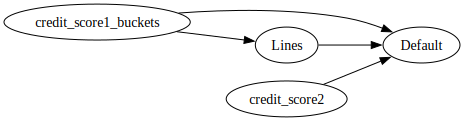

In [481]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Lines"),
g.edge("credit_score2", "Default"),
g.edge("Lines", "Default")

g

In [496]:
formula_neutral = "default~credit_limit+C(credit_score1_buckets)+credit_score2"
model_neutral = bmb.Model(formula, data=risk_data_rnd)
result_neutral = model.fit(cores=1, idata_kwargs=dict(log_likelihood = True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, C(credit_score1_buckets), credit_score2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 90 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [508]:
formula_og = "default~credit_limit+C(credit_score1_buckets)"
model_og= bmb.Model(formula_og, data=risk_data_rnd)
result_og = model_og.fit(cores=1, idata_kwargs=dict(log_likelihood = True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [default_sigma, Intercept, credit_limit, C(credit_score1_buckets)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 69 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [509]:
az.summary(result_neutral, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.553300,0.057501,0.440847,0.654127,2.581048e-03,1.826150e-03,502.164447,529.729927,1.005560
credit_limit,0.000005,0.000002,0.000002,0.000009,4.200000e-08,3.000000e-08,2053.434696,1253.185912,1.000520
C(credit_score1_buckets)[200],-0.033561,0.056718,-0.132787,0.079170,2.647339e-03,1.873142e-03,459.843237,614.338383,1.007900
C(credit_score1_buckets)[400],-0.098202,0.056541,-0.208034,0.003577,2.652833e-03,1.877042e-03,458.031937,648.013704,1.006003
C(credit_score1_buckets)[600],-0.135824,0.056920,-0.242624,-0.031384,2.666747e-03,1.886884e-03,455.877741,483.831511,1.006775
C(credit_score1_buckets)[800],-0.110578,0.059383,-0.224627,-0.004770,2.774889e-03,1.963394e-03,459.329864,631.828482,1.007823
C(credit_score1_buckets)[1000],-0.036679,0.091122,-0.214347,0.127712,3.419857e-03,2.419198e-03,716.684322,855.130481,1.003077
credit_score2,-0.000707,0.000025,-0.000754,-0.000658,5.460000e-07,3.870000e-07,2078.073330,1124.484608,1.000177
default_sigma,0.274730,0.001938,0.271314,0.278508,4.718500e-05,3.337000e-05,1685.843865,1547.886313,1.000104


In [510]:
az.summary(result_og, round_to=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.220511,0.054974,1.240915e-01,0.330998,2.342237e-03,1.657090e-03,552.075056,788.575385,1.002315
credit_limit,0.000005,0.000002,4.720000e-07,0.000008,5.300000e-08,3.800000e-08,1571.239041,1387.555736,1.001153
C(credit_score1_buckets)[200],-0.050828,0.055963,-1.617281e-01,0.049086,2.417069e-03,1.710057e-03,537.018856,727.449626,1.002724
C(credit_score1_buckets)[400],-0.139073,0.055751,-2.509786e-01,-0.041592,2.418417e-03,1.711018e-03,533.424488,745.278467,1.002380
C(credit_score1_buckets)[600],-0.209407,0.056372,-3.230494e-01,-0.111128,2.442405e-03,1.727987e-03,535.542252,745.023039,1.002508
C(credit_score1_buckets)[800],-0.243144,0.058179,-3.496006e-01,-0.134667,2.439962e-03,1.726200e-03,573.232251,859.988976,1.001964
C(credit_score1_buckets)[1000],-0.251493,0.093455,-4.218990e-01,-0.079716,3.205848e-03,2.267655e-03,848.201791,1080.336346,1.000885
default_sigma,0.286946,0.002024,2.831400e-01,0.290623,4.505700e-05,3.187100e-05,2019.168267,1394.531582,0.999982


In [511]:
az.compare({'neutral_control': result_neutral, 'og': result_og}, ic = 'waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
neutral_control,0,-1275.023793,11.585617,0.000000,1.0,127.037239,0.000000,True,log
og,1,-1711.171987,10.327349,436.148194,0.0,136.667487,29.460544,False,log


Using WAIC we can confirm the result seen in the book. Even though we have an extra parameter which increases the variance this is overwritten by the predictivity increases provided by "credit_score2" to the model.

### Noise Inducing Control


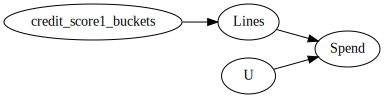

In [57]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("credit_score1_buckets", "Lines"),
g.edge("U", "Spend"),
g.edge("Lines", "Spend")

g

In [58]:
spend_data_rnd = pd.read_csv("data/spend_data_rnd.csv")

model = bmb.Model("spend ~ np.sqrt(credit_limit)",
                data=spend_data_rnd)

result = model.fit(cores=1)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [ ]:
az.summary(result)

In [59]:
model = smf.ols("spend~np.sqrt(credit_limit)+C(credit_score1_buckets)",
                data=spend_data_rnd)
result = model.fit(cores=1)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


In [ ]:
az.summary(result)

### Feature Selection: A Bias-Variance Trade-Off


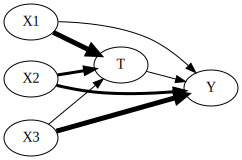

In [60]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})


g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", penwidth="3"),
g.edge("X3", "T", penwidth="1"),

g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", penwidth="3"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

In [61]:
np.random.seed(123)

n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [62]:
smf.ols("y~t+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


## Key Ideas


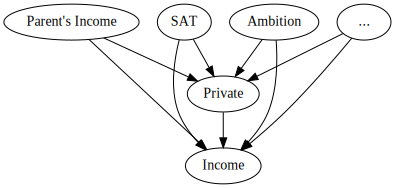

In [63]:
import graphviz as gr

g = gr.Digraph(format="png")

g.edge("Parent's Income", "Private")
g.edge("SAT", "Private")
g.edge("Ambition", "Private")
g.edge("...", "Private")

g.edge("Parent's Income", "Income")
g.edge("SAT", "Income")
g.edge("Ambition", "Income")
g.edge("...", "Income")

g.edge("Private", "Income")

g